# Generative Adversarial Networks

For this part of the assignment you implement two different types of generative adversarial networks. We will train the networks on the Celeb A dataset which is a large set of celebrity face images.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
HOME_DIR = os.getcwd()
PWD = os.path.join(HOME_DIR, 'gdrive', 'MyDrive', 'Colab Notebooks', 'CS498', 'assignment4_materials')
print(PWD)
os.chdir(PWD)
# print(HOME_DIR)

/content/gdrive/MyDrive/Colab Notebooks/CS498/assignment4_materials


In [ ]:
# Download celeb data
!chmod u+rwx download_celeba.sh
!./download_celeba.sh

--2021-04-20 18:33:45--  https://uofi.box.com/shared/static/q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip
Resolving uofi.box.com (uofi.box.com)... 107.152.24.197
Connecting to uofi.box.com (uofi.box.com)|107.152.24.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip [following]
--2021-04-20 18:33:45--  https://uofi.box.com/public/static/q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip
Reusing existing connection to uofi.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://uofi.app.box.com/public/static/q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip [following]
--2021-04-20 18:33:45--  https://uofi.app.box.com/public/static/q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip
Resolving uofi.app.box.com (uofi.app.box.com)... 107.152.24.201
Connecting to uofi.app.box.com (uofi.app.box.com)|107.152.24.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcl

In [ ]:
# move the zip file to Kontent and unpack
if True:
  import shutil 
  shutil.copyfile("q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip", "/content/q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip")
  os.makedirs('/content/celeba_data', exist_ok=True)
  !unzip "q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip" -d "/content/celeba_data"

Streaming output truncated to the last 5000 lines.
  inflating: /content/celeba_data/celeba_train_128res/175430_crop.jpg  
  inflating: /content/celeba_data/celeba_train_128res/157564_crop.jpg  
  inflating: /content/celeba_data/celeba_train_128res/039881_crop.jpg  
  inflating: /content/celeba_data/celeba_train_128res/150303_crop.jpg  
  inflating: /content/celeba_data/celeba_train_128res/145071_crop.jpg  
  inflating: /content/celeba_data/celeba_train_128res/165362_crop.jpg  
  inflating: /content/celeba_data/celeba_train_128res/197644_crop.jpg  
  inflating: /content/celeba_data/celeba_train_128res/015423_crop.jpg  
  inflating: /content/celeba_data/celeba_train_128res/188193_crop.jpg  
  inflating: /content/celeba_data/celeba_train_128res/124213_crop.jpg  
  inflating: /content/celeba_data/celeba_train_128res/160818_crop.jpg  
  inflating: /content/celeba_data/celeba_train_128res/169663_crop.jpg  
  inflating: /content/celeba_data/celeba_train_128res/066406_crop.jpg  
  inflating: 

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 1

%aimport gan.losses
%aimport gan.train
%aimport gan.models
%aimport gan.spectral_normalization

In [ ]:
from gan.train import train

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# GAN loss functions

In this assignment you will implement two different types of GAN cost functions. You will first implement the loss from the [original GAN paper](https://arxiv.org/pdf/1406.2661.pdf). You will also implement the loss from [LS-GAN](https://arxiv.org/abs/1611.04076). 

### GAN loss

**TODO:** Implement the `discriminator_loss` and `generator_loss` functions in `gan/losses.py`.

The generator loss is given by:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: You should use the `torch.nn.functional.binary_cross_entropy_with_logits` function to compute the binary cross entropy loss since it is more numerically stable than using a softmax followed by BCE loss. The BCE loss is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$


Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [ ]:
from gan.losses import discriminator_loss, generator_loss

### Least Squares GAN loss

**TODO:** Implement the `ls_discriminator_loss` and `ls_generator_loss` functions in `gan/losses.py`.

We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

In [ ]:
from gan.losses import ls_discriminator_loss, ls_generator_loss

# GAN model architecture

**TODO:** Implement the `Discriminator` and `Generator` networks in `gan/models.py`.

We recommend the following architectures which are inspired by [DCGAN](https://arxiv.org/pdf/1511.06434.pdf):

**Discriminator:**

- convolutional layer with in_channels=3, out_channels=128, kernel=4, stride=2
- convolutional layer with in_channels=128, out_channels=256, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=256, out_channels=512, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=512, out_channels=1024, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=1024, out_channels=1, kernel=4, stride=1

Use padding = 1 (not 0) for all the convolutional layers.

Instead of Relu we LeakyReLu throughout the discriminator (we use a negative slope value of 0.2). You can use simply use relu as well.

The output of your discriminator should be a single value score corresponding to each input sample. See `torch.nn.LeakyReLU`.


**Generator:**

**Note:** In the generator, you will need to use transposed convolution (sometimes known as fractionally-strided convolution or deconvolution). This function is implemented in pytorch as `torch.nn.ConvTranspose2d`.

- transpose convolution with in_channels=NOISE_DIM, out_channels=1024, kernel=4, stride=1
- batch norm
- transpose convolution with in_channels=1024, out_channels=512, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=512, out_channels=256, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=256, out_channels=128, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=128, out_channels=3, kernel=4, stride=2

The output of the final layer of the generator network should have a `tanh` nonlinearity to output values between -1 and 1. The output should be a 3x64x64 tensor for each sample (equal dimensions to the images from the dataset).





# Data loading: Celeb A Dataset

The CelebA images we provide have been filtered to obtain only images with clear faces and have been cropped and downsampled to 128x128 resolution.

In [ ]:
batch_size = 128
scale_size = 64  # We resize the images to 64x64 for training

celeba_root = '/content/celeba_data'

In [ ]:
celeba_train = ImageFolder(root=celeba_root, transform=transforms.Compose([
  transforms.Resize(scale_size),
  transforms.ToTensor(),
]))

celeba_loader_train = DataLoader(celeba_train, batch_size=batch_size, drop_last=True)

### Visualize dataset

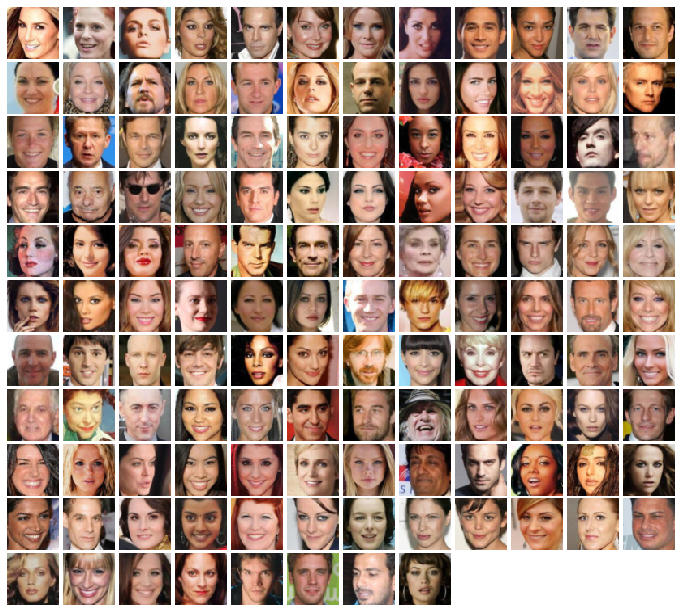

In [ ]:
from gan.utils import show_images

imgs = celeba_loader_train.__iter__().next()[0].numpy().squeeze()
show_images(imgs, color=True)

# Training 


**TODO:** Fill in the training loop in `gan/train.py`.

In [ ]:
NOISE_DIM = 100
NUM_EPOCHS = 20
learning_rate = 0.0002

### Train GAN

In [ ]:
from gan.models import Discriminator, Generator
from gan.spectral_normalization import SpectralNorm

In [ ]:
D = Discriminator().to(device)
G = Generator(noise_dim=NOISE_DIM).to(device)

In [ ]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas = (0.5, 0.999))

### Since the ouput is >100 pages long, Google Colab doesn't render it while printing to PDF. If you want to see the outputs, please let me know and I can give you view access to the original notebook on Colab.

In [ ]:
# original gan
train(D, G, D_optimizer, G_optimizer, discriminator_loss, 
          generator_loss, num_epochs=NUM_EPOCHS, show_every=150,
          train_loader=celeba_loader_train, device=device)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
if False:
  torch.save(D.state_dict(), './nsgan_discriminator.pth')
  torch.save(G.state_dict(), './nsgan_generator.pth')

### Train GAN without spectral normalization

In [ ]:
D = Discriminator(with_spectral_norm = False).to(device)
G = Generator(noise_dim=NOISE_DIM).to(device)

In [ ]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas = (0.5, 0.999))

### Since the ouput is >100 pages long, Google Colab doesn't render it while printing to PDF. If you want to see the outputs, please let me know and I can give you view access to the original notebook on Colab.

In [ ]:
# original gan without spectral normalization
train(D, G, D_optimizer, G_optimizer, discriminator_loss, 
          generator_loss, num_epochs=NUM_EPOCHS, show_every=150,
          train_loader=celeba_loader_train, device=device)


Output hidden; open in https://colab.research.google.com to view.

### Train LS-GAN

In [ ]:
D = Discriminator().to(device)
G = Generator(noise_dim=NOISE_DIM).to(device)

In [ ]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas = (0.5, 0.999))

### Since the ouput is >100 pages long, Google Colab doesn't render it while printing to PDF. If you want to see the outputs, please let me know and I can give you view access to the original notebook on Colab.

In [ ]:
# ls-gan
train(D, G, D_optimizer, G_optimizer, ls_discriminator_loss, 
          ls_generator_loss, num_epochs=NUM_EPOCHS, show_every=200,
          train_loader=celeba_loader_train, device=device)

Output hidden; open in https://colab.research.google.com to view.

## Extra credit assignment

Change the network architecture and hyperparameters to train on the full 128x128 resolution CelebA data in the preprocessed dataset we provide rather than the 64x64 resized samples we train on currently.

In [ ]:
from gan.models import Discriminator128, Generator128
from gan.spectral_normalization import SpectralNorm
from gan.train import train

In [ ]:
NOISE_DIM = 100
NUM_EPOCHS = 20
learning_rate = 0.0002

In [ ]:
batch_size = 128
scale_size = 128  # We resize the images to 64x64 for training

celeba_root_128 = '/content/celeba_data/'
celeba_train_128 = ImageFolder(root=celeba_root_128, transform=transforms.Compose([
  transforms.Resize(scale_size),
  transforms.ToTensor(),
]))

celeba_128_loader_train = DataLoader(celeba_train_128, batch_size=batch_size, drop_last=True)

In [ ]:
D = Discriminator128().to(device)
G = Generator128(noise_dim=NOISE_DIM).to(device)

In [ ]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas = (0.5, 0.999))

In [ ]:
# ls-gan witth different formulation
train(D, G, D_optimizer, G_optimizer, ls_discriminator_loss, 
          ls_generator_loss, num_epochs=NUM_EPOCHS, show_every=200,
          train_loader=celeba_128_loader_train, device=device)

Output hidden; open in https://colab.research.google.com to view.

From disk option added, but no stored state found, beginning from scratch
EPOCH:  1
Iter: 0, D: 1.372, G:57.85


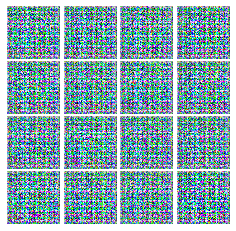


Iter: 200, D: 0.02388, G:0.487


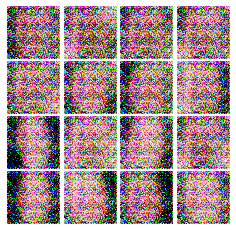


Iter: 400, D: 0.09861, G:0.2286


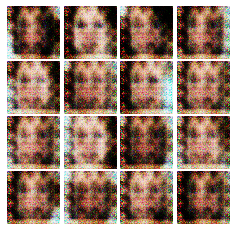


Iter: 600, D: 0.1697, G:0.2566


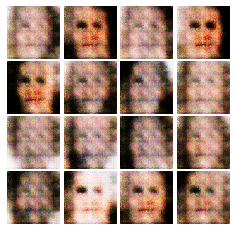


Iter: 800, D: 0.3584, G:0.8386


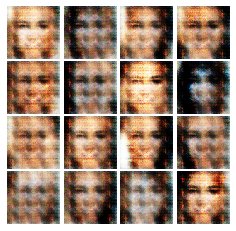


EPOCH:  2
Iter: 1000, D: 0.473, G:0.2873


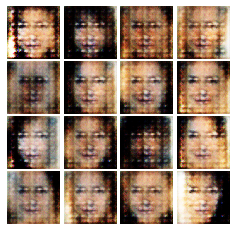


Iter: 1200, D: 0.08431, G:0.3424


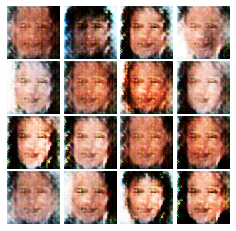


Iter: 1400, D: 0.1572, G:0.4963


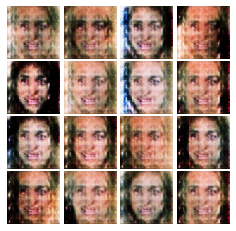


Iter: 1600, D: 0.1239, G:0.4987


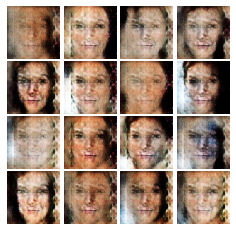


Iter: 1800, D: 0.1039, G:0.341


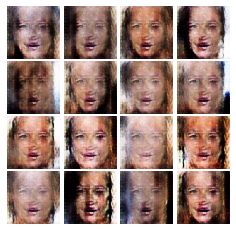


EPOCH:  3
Iter: 2000, D: 0.0783, G:0.5792


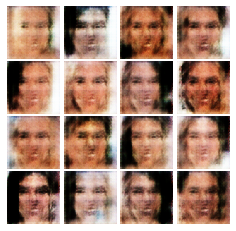


Iter: 2200, D: 0.1514, G:0.4752


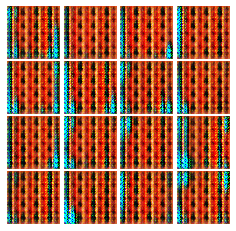


Iter: 2400, D: 0.4324, G:0.1348


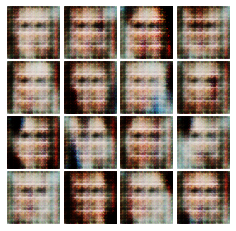


Iter: 2600, D: 0.1374, G:0.3461


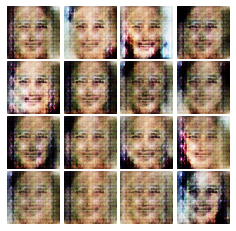


Iter: 2800, D: 0.2023, G:0.6817


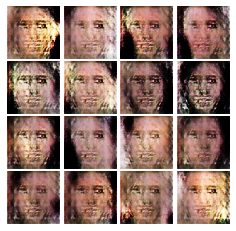


EPOCH:  4
Iter: 3000, D: 0.2175, G:0.8115


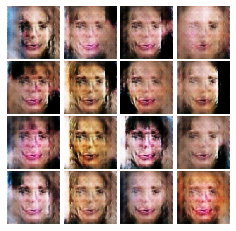


Iter: 3200, D: 0.1153, G:0.6016


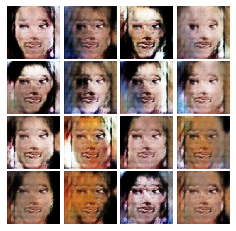


Iter: 3400, D: 0.05418, G:0.2829


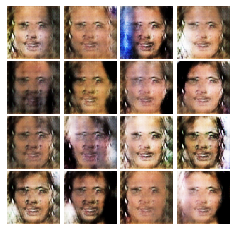


Iter: 3600, D: 0.05984, G:0.3474


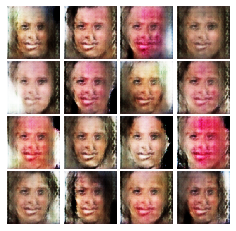


Iter: 3800, D: 0.2222, G:0.2848


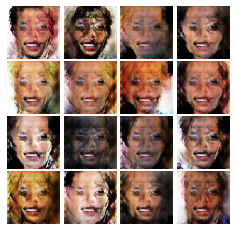


EPOCH:  5
Iter: 4000, D: 0.06055, G:0.4072


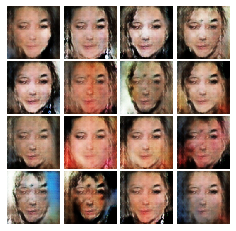


Iter: 4200, D: 0.07466, G:0.3986


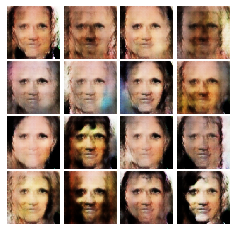


Iter: 4400, D: 0.1095, G:0.6046


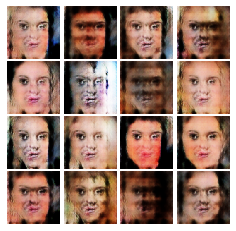


Iter: 4600, D: 0.06316, G:0.3141


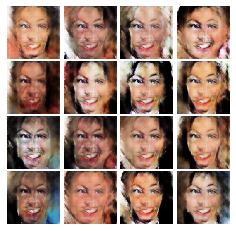


Iter: 4800, D: 0.1502, G:0.749


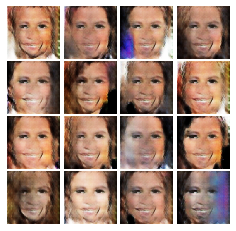


EPOCH:  6
Iter: 5000, D: 0.1095, G:0.6102


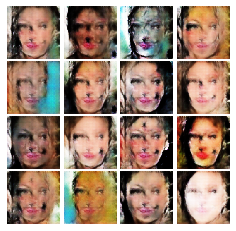


Iter: 5200, D: 0.05423, G:0.447


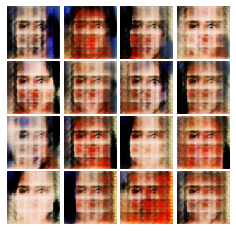


Iter: 5400, D: 0.1129, G:0.4079


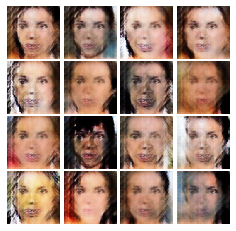


Iter: 5600, D: 0.04816, G:0.4514


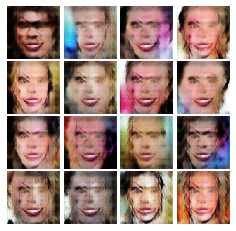


Iter: 5800, D: 0.2341, G:0.514


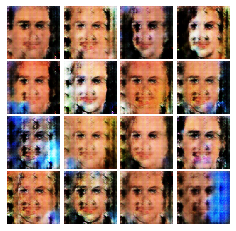


EPOCH:  7
Iter: 6000, D: 0.01872, G:0.3924


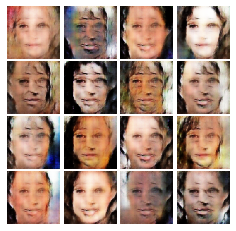

In [ ]:
# ls-gan for 128x128
train(D, G, D_optimizer, G_optimizer, ls_discriminator_loss, 
          ls_generator_loss, num_epochs=NUM_EPOCHS, show_every=200,
          train_loader=celeba_128_loader_train, device=device, from_disk=True)